## Image segmentation with U-Net

This part of the homework is about image segmentation with <a href="https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/" class="external">U-Net</a>.

### What is image segmentation?

There is a large number of tasks where you need to know not only the presence of an object in the picture, but its location and exact shape.This is precisely the task that image segmentation copes with, which puts a class label for each pixel, as opposed to image classification, which labels each image.

This task uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/), created by Parkhi *et al*. The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the train and test split). Each pixel of an animal image corresponds to one of three classes: a pixel belonging to a pet; a pixel located at the border of a pet; all other pixels. 

Данное задание предстоит выполнить на фреймворке Tensorflow 2 с помощью Ke ras, подробнее о том, как использовать Keras и примеры вы можете найти по [ссылке](https://www.tensorflow.org/guide/keras/sequential_model)

### Preprocessing

#### Download the data

Please make sure you select the **GPU** runtime environment!!!

In [33]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-05-28 16:44:01--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-05-28 16:44:02--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz [following]
--2023-05-28 16:44:02--  https://thor.robots.ox.ac.uk/datasets/pets/images.tar.gz
Reusing existing connection to thor.robots.ox.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-str

#### Prepare paths of input images

In [2]:
import os 

def get_paths(files_dir: str, files_type: str):
    paths = sorted(
        [
            os.path.join(files_dir, file_name)
            for file_name in os.listdir(files_dir)
            if file_name.endswith(f".{files_type}") and not file_name.startswith(".")
        ]
    )
    return paths


images_dir = "images/"
masks_dir = "annotations/trimaps/"

images_paths = get_paths(images_dir, "jpg")
masks_paths = get_paths(masks_dir, "png")

img_size = (128, 128)
num_classes = 3

print("Number of samples:", len(images_paths))

Number of samples: 7390


#### Show example of data

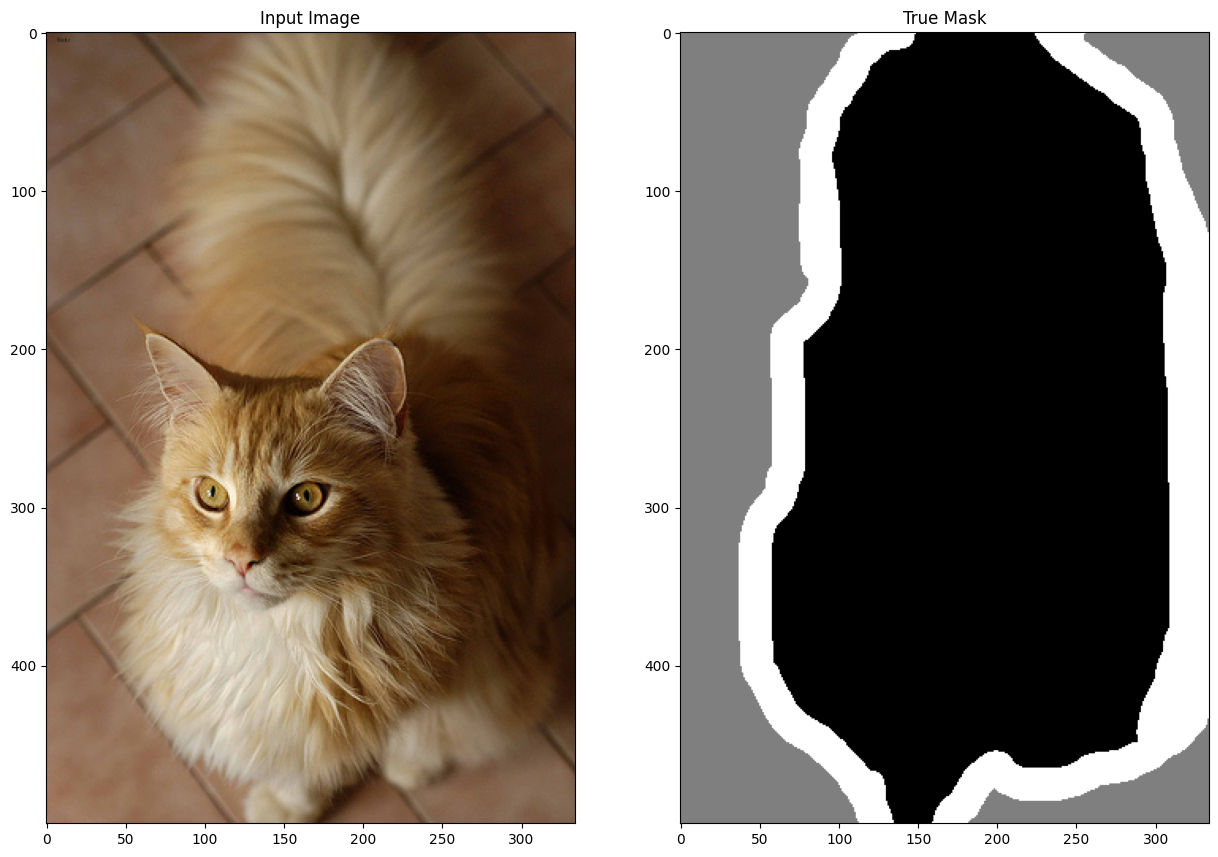

In [35]:
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

import numpy as np
import matplotlib.pyplot as plt

# display original image, true mask, and predicted mask (optional)
# all images are np.arrays or PIL.Image
def display_sample(display_list):
    titles = ['Input Image', 'True Mask', 'Predicted Mask'][:len(display_list)]
    plt.figure(figsize=(15, 15))
    columns = len(titles)
    
    for i, image in enumerate(display_list):
        plt.subplot(1, columns, i + 1)
        plt.title(titles[i])
        plt.imshow(np.asarray(image))
    
def load_image_and_mask(images_paths, masks_paths, ind):
    image = load_img(images_paths[ind])
    mask = PIL.ImageOps.autocontrast(load_img(masks_paths[ind]))
    return (image, mask, )

sample = load_image_and_mask(images_paths, masks_paths, 1234)
display_sample(sample)

#### Task 1: Set Sequence for training process

In this task you need to implement two methods for the Sequence class used for model training and validation: __len__ and __getitem__.



Note: `Sequence` are a safer way to do multiprocessing. This structure guarantees
that the network will only train once
on each sample per epoch which is not the case with generators.

In [61]:
import tensorflow
from keras.utils.image_dataset import load_image
from tensorflow import keras



class PetsSequence(keras.utils.Sequence):
    
    def __init__(self, batch_size, img_size, images_paths, masks_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.images_paths = images_paths
        self.masks_paths = masks_paths
        
    
    def __len__(self):
        # Each item in the sequence has a size of batch_size, this method returns the number of batches. Shoud be integer!
        # TODO: length calculation
        return int(len(self.images_paths) / self.batch_size)
    
    def __getitem__(self, idx):
        x = np.zeros((self.batch_size, ) + self.img_size + (3, ), dtype="float32")
        y = np.zeros((self.batch_size, ) + self.img_size + (1, ), dtype="uint8")
        """
        This method returns the batches themselves including images (x) and masks (y) as np.arrays.
        Correspondingly x contains the batch_size of the pet images, y the true segmentation of the images from x.
        Note:
            1) You can use tensorflow.keras.preprocessing.image.load_img with the specified parameter "target_size" 
                (for reading masks for reading masks is a convenient is parametercolor_mode="grayscale")
            2) Don't forget to normalize the images and masks 
                ( img / 255.0 for images, so that each value is adjacent to the interval [0, 1] 
                and mask -= 1 for segmented images, to get {0, 1, 2} instead of the original labels {1, 2, 3} ) 
        """
        
        # TODO x and y calculation
        batch_idx = idx * self.batch_size

        batch_img_path = self.images_paths[batch_idx: batch_idx + self.batch_size]
        for j, path in enumerate (batch_img_path):
          img = load_img(path, target_size = self.img_size)
          x_norm = tensorflow.cast(img, tensorflow.float32) #https://stackoverflow.com/questions/57454271/should-i-still-normalize-image-data-divide-by-255-before-using-per-image-stand
          x[j] = x_norm / 255.0

        batch_mask_path = self.masks_paths[batch_idx: batch_idx + self.batch_size]
        for j, path in enumerate(batch_mask_path):
          img = load_img(path, target_size = self.img_size, color_mode='grayscale')
          y[j] = np.expand_dims(img, 2) #https://numpy.org/doc/stable/reference/generated/numpy.expand_dims.html
          y[j] -= 1

        return x, y



Test for task 1. Please do not change the code in the cell below, it is just to make sure that your implementation of Sequence is set correctly

In [60]:
print(y.sum())
print(x.sum())

438676
167121950.0


In [62]:
sequence = PetsSequence(32, (128, 128), images_paths, masks_paths)


if type(sequence.__len__()) != int:
    print("Error: __len__ value should be integer \n")
elif not (sequence.__len__() == 230 or sequence.__len__() == 231):
    print("Wrong answer for __len__ realization\n")
else:
    print("Method __len__ is correct!")
    
if len(sequence.__getitem__(5)) != 2:
    print("Error: __getitem__ Must return a tuple of two elements") 
else:
    x, y = sequence.__getitem__(5)
    if type(x) != np.ndarray or type(y) != np.ndarray:
        print("Error: x and y shoud have type numpy.ndarray")
    elif x.shape != (32, 128, 128, 3):
        print("Error: x shoud has shape (batch_size, img_size_x, img_size_y, 3)")
    elif y.shape != (32, 128, 128, 1):
        print("Error: y shoud has shape (batch_size, img_size_x, img_size_y, 1)")
    elif y.sum() == 962964:
        print("Wrong answer: there is no normalization for y")
    elif y.sum() != 438676:
        print("Wrong answer for y")
    elif x.sum() >= 167121500.0 and x.sum() <= 167122500.0:
        print("Wrong answer: there is no normalization for x")
    elif not (x.sum() >= 655200.0 and x.sum() <= 655600.0):
        print("Wrong answer for x")
    else:
        print("Method __getitem__ is correct!")

Method __len__ is correct!
Method __getitem__ is correct!


### Base U-Net

#### Task 2: U-Net architecture

In this task you need to describe the architecture of the neural network by implementing the get_unet_model method.

Note: You can use padding="same" in convolution layers to simplify the network structure and avoid cropping.

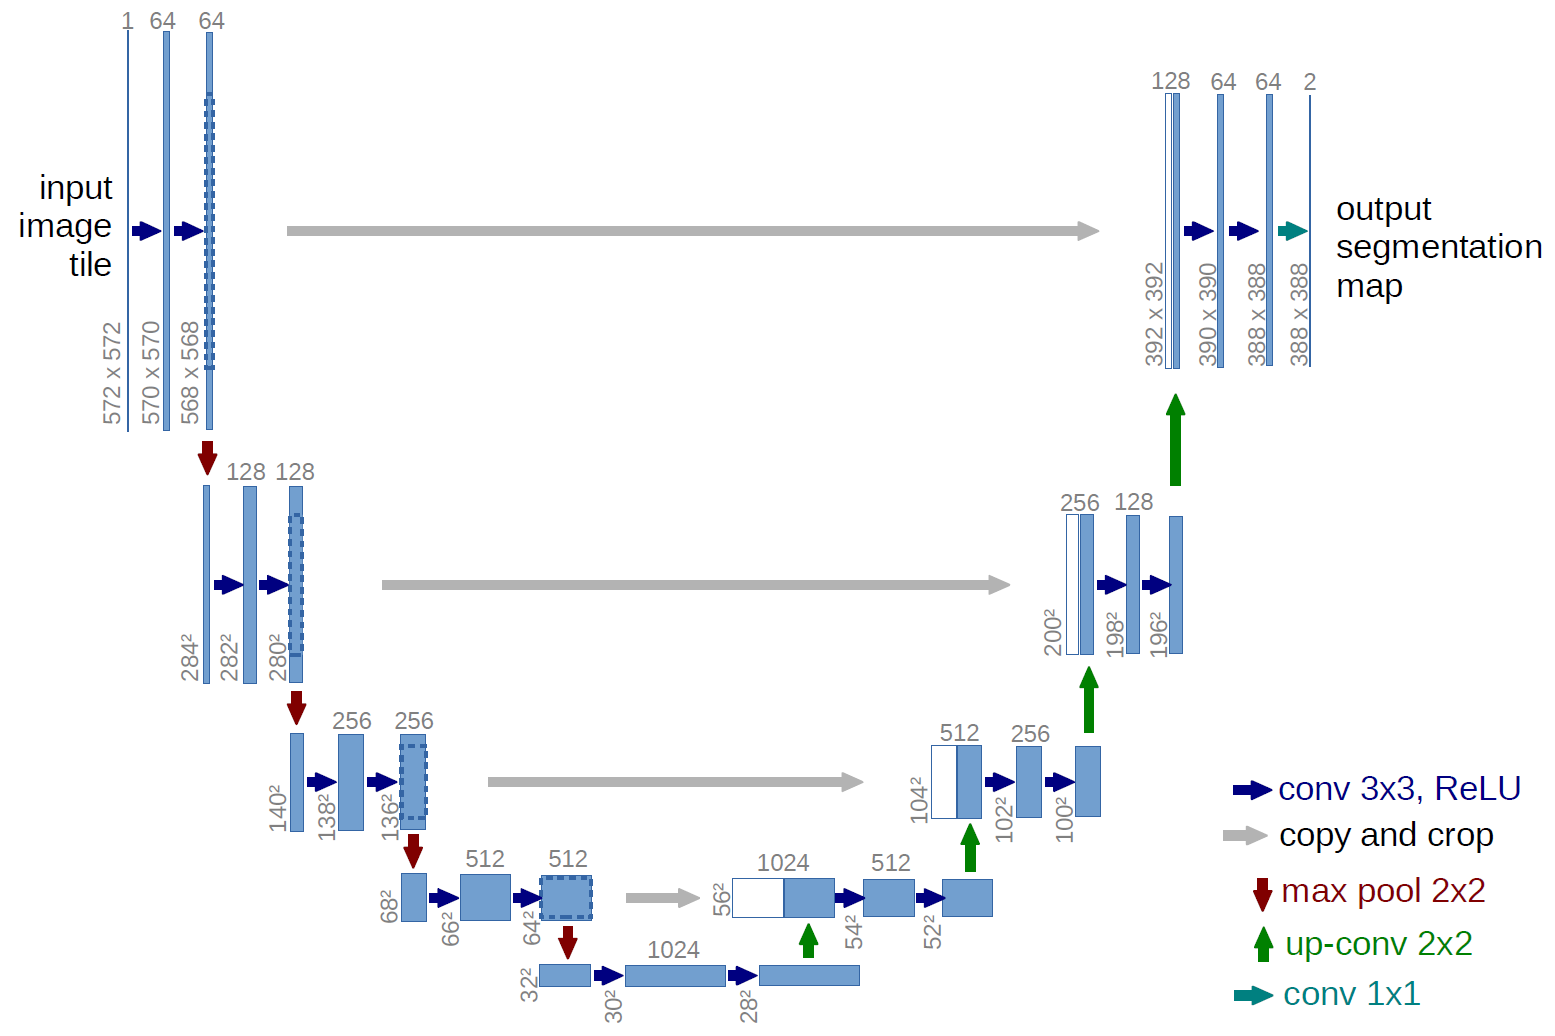



In this task you will be able to use MaxPooling2D(pool_size=(2, 2)), UpSampling2D(size = (2,2)), Concatenate().

In [67]:
from tensorflow.keras.layers import Input, Conv2D, Concatenate, MaxPooling2D, UpSampling2D

def get_unet_model(img_size, num_classes):

    inputs = keras.Input(shape=img_size+(3,))
    
    # --- Encoder ---
    # first conv layer
    conv_layer_1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    # TODO other layers of encoder
    conv_layer_1 = Conv2D(64, 3, activation='relu', padding='same')(conv_layer_1)
    #pool_size = (2, 2)
    pool_1 = MaxPooling2D(pool_size=(2,2))(conv_layer_1)

    conv_layer_2 = Conv2D(128, 3, activation='relu', padding='same')(pool_1)
    conv_layer_2 = Conv2D(128, 3, activation='relu', padding='same')(conv_layer_2)
    #pool_size = (2, 2)
    pool_2 = MaxPooling2D(pool_size=(2,2))(conv_layer_2)

    conv_layer_3 = Conv2D(256, 3, activation='relu', padding='same')(pool_2)
    conv_layer_3 = Conv2D(256, 3, activation='relu', padding='same')(conv_layer_3)
    #pool_size = (2, 2)
    pool_3 = MaxPooling2D(pool_size=(2,2))(conv_layer_3)
    
    conv_layer_4 = Conv2D(512, 3, activation='relu', padding='same')(pool_3)
    conv_layer_4 = Conv2D(512, 3, activation='relu', padding='same')(conv_layer_4)
    #pool_size = (2, 2)
    pool_4 = MaxPooling2D(pool_size=(2,2))(conv_layer_4)

    conv_layer_5 = Conv2D(1024, 3, activation='relu', padding='same')(pool_4)
    conv_layer_5 = Conv2D(1024, 3, activation='relu', padding='same')(conv_layer_5)
    #pool_size = (2, 2)
    #pool_5 = MaxPooling2D(pool_size=(2,2))(conv_layer_5)
    # --- End of Encoder
    # --- Decoder --- 
    
    up_dec = Conv2D(512, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv_layer_5))
    # TODO other layers of decoder
    concat_1 = Concatenate()([conv_layer_4, up_dec])
    conv_layer_6 = Conv2D(512, 2, activation='relu', padding='same')(concat_1)
    conv_layer_6 = Conv2D(512, 2, activation='relu', padding='same')(conv_layer_6)

    up_dec_1 = Conv2D(256, 3, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv_layer_6))
    concat_2 = Concatenate()([conv_layer_3, up_dec_1])
    conv_layer_7 = Conv2D(256, 3, activation='relu', padding='same')(concat_2)
    conv_layer_7 = Conv2D(256, 3, activation='relu', padding='same')(conv_layer_7)

    up_dec_2 = Conv2D(128, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv_layer_7))
    concat_3 = Concatenate()([conv_layer_2, up_dec_2])
    conv_layer_8 = Conv2D(128, 3, activation='relu', padding='same')(concat_3)
    conv_layer_8 = Conv2D(128, 3, activation='relu', padding='same')(conv_layer_8)

    up_dec_3 = Conv2D(64, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv_layer_8))
    concat_4 = Concatenate()([conv_layer_1, up_dec_3])
    last_conv = Conv2D(128, 3, activation='relu', padding='same')(concat_4)
    last_conv = Conv2D(64, 3, activation='relu', padding='same')(last_conv)
    # --- End of Decoder ---
    
    
    outputs = Conv2D(num_classes, 3, activation="softmax", padding="same")(last_conv)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()
model = get_unet_model(img_size, num_classes)

You can check the correctness of the model by comparing the U-Net architecture and the output of keras.utils.plot_model

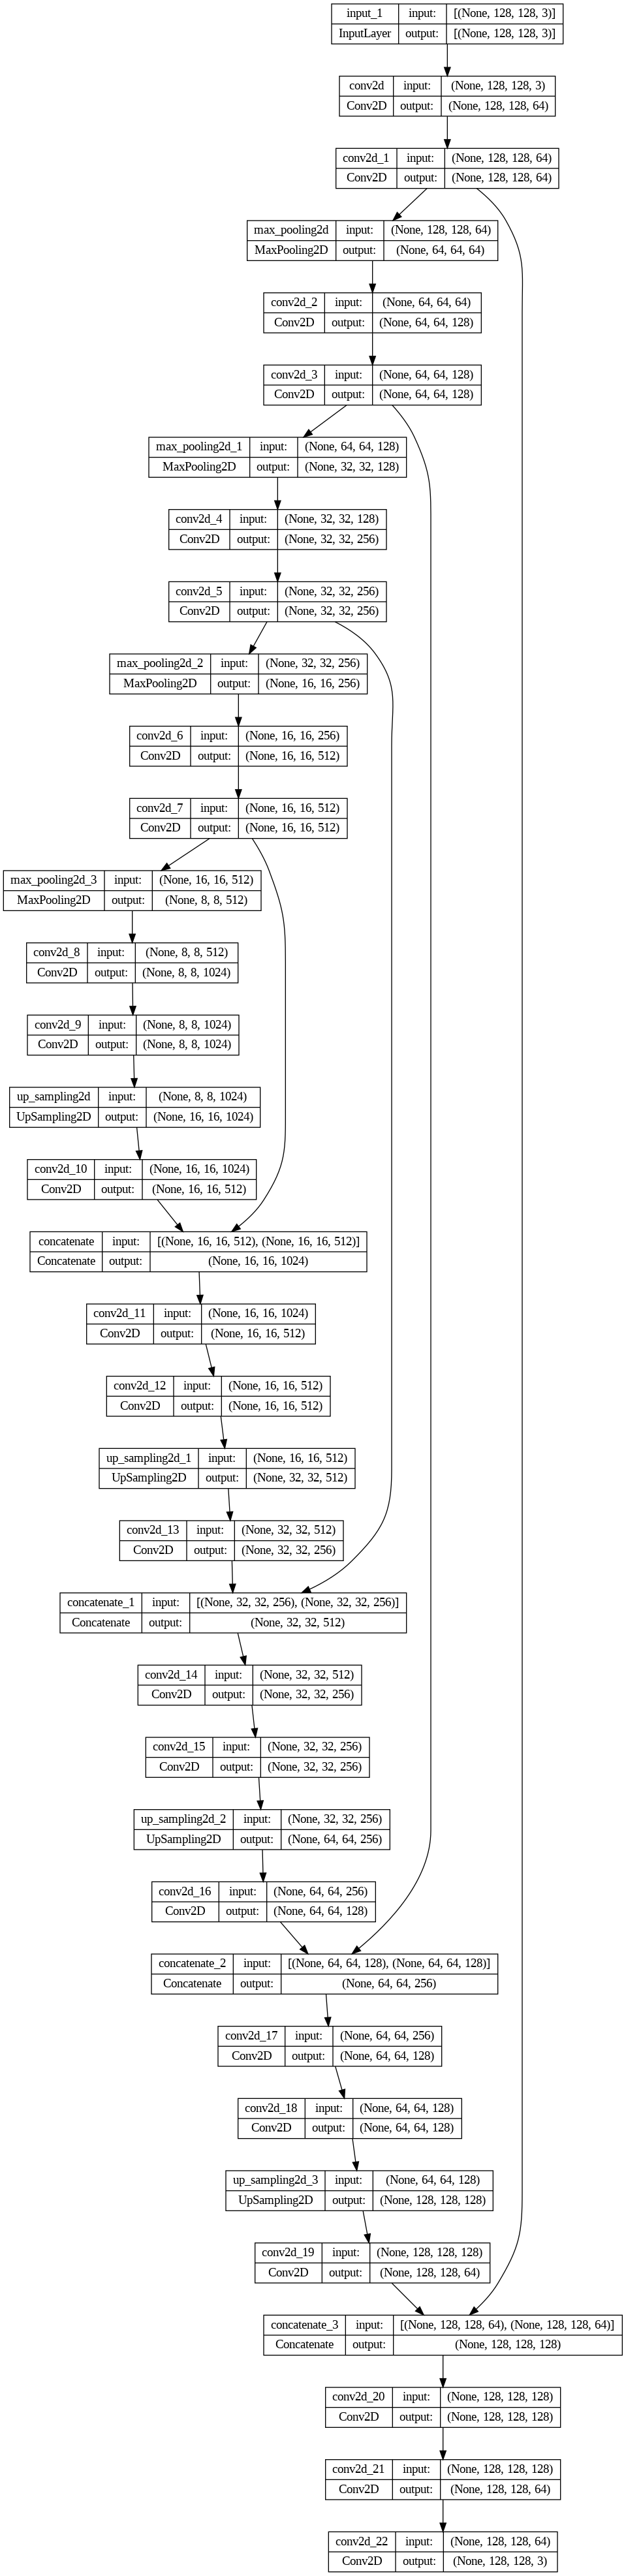

In [68]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [69]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(images_paths)
random.Random(1337).shuffle(masks_paths)
train_input_img_paths = images_paths[:-val_samples]
train_target_img_paths = masks_paths[:-val_samples]
val_input_img_paths = images_paths[-val_samples:]
val_target_img_paths = masks_paths[-val_samples:]

# Instantiate data Sequences for each split
batch_size = 32
train_gen = PetsSequence(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = PetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [70]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")


# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
199/199 [==============================] - 179s 736ms/step - loss: 0.9030 - val_loss: 0.8027
Epoch 2/15
199/199 [==============================] - 148s 743ms/step - loss: 0.7872 - val_loss: 0.6805
Epoch 3/15
199/199 [==============================] - 147s 740ms/step - loss: 0.7047 - val_loss: 0.7684
Epoch 4/15
199/199 [==============================] - 147s 736ms/step - loss: 0.6446 - val_loss: 0.6156
Epoch 5/15
199/199 [==============================] - 146s 734ms/step - loss: 0.6029 - val_loss: 0.7409
Epoch 6/15
199/199 [==============================] - 147s 740ms/step - loss: 0.5575 - val_loss: 0.5980
Epoch 7/15
199/199 [==============================] - 147s 739ms/step - loss: 0.5265 - val_loss: 0.5000
Epoch 8/15
199/199 [==============================] - 147s 740ms/step - loss: 0.4893 - val_loss: 0.5489
Epoch 9/15
199/199 [==============================] - 147s 741ms/step - loss: 0.4581 - val_loss: 0.4775
Epoch 10/15
199/199 [==============================] - 147s 739m

In [71]:
# predict segmentation for validation dataset
# It is not necessary to predict the result for the whole dataset, you can limit yourself to one bitch from the validation dataset 

val_gen = PetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

31/31 [==============================] - 11s 340ms/step


In [72]:
def prediction_to_img(prediction):
    prediction = np.argmax(prediction, axis=-1)
    prediction = np.expand_dims(prediction, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(prediction))
    return img 

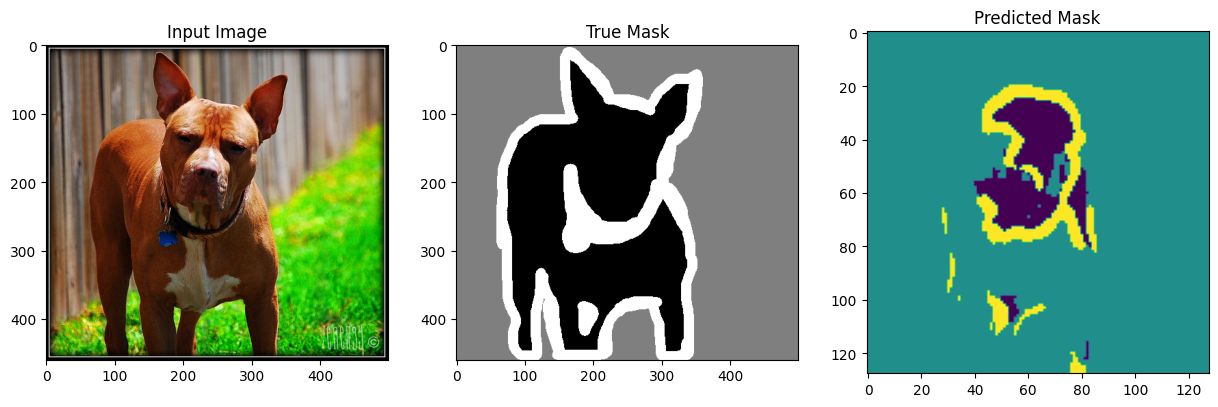

In [73]:
# display one sample prediction

i = 7

sample = load_image_and_mask(val_input_img_paths, val_target_img_paths, i)
prediction = prediction_to_img(val_preds[i])
sample += (prediction,)

display_sample(sample)

### Using pretrained models for optimization of U-Net

#### Definition of U-Net encoder by pretrained MobileNetV2

We will use the already trained MobileNetV2 encoder for U-Net, and only the decoder will be trained in the process.

In [74]:
base_model = keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


#### Task 3: U-Net architecture with MobileNetV2 encoder

In [75]:
# install tensorflow_examples
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-yb9ea35h
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-yb9ea35h
  Resolved https://github.com/tensorflow/examples.git to commit b0b0e9d0cf74a7f7dc84ab4ace616121dc5acc1a
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1684213865.1008727675037047473993687338480666859982076693530-py3-none-any.whl size=299994 sha256=e961c068253d1d1efe40deb1c51df16fab7cdb91f7e109b0a219332f216a188a
  Stored in directory: /tmp/pip-ephem-wheel-cache-u6y1vp9k/wheels/72/5f/d0/7fe769eaa229bf20101d11a357eb23c83c481bee2d7f710599
Successfully built tensorflow-examples


In [76]:
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow.keras.layers import Input, Conv2DTranspose, Concatenate

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def get_unet_with_mobile_net_v2(img_size: list, num_classes:int):
    inputs = Input(shape=img_size + (3,))

    # pretrained encoder layer
    skips = down_stack(inputs)
    
    
    # --- Decoder --- 
    # the first part of the decoder
    up_dec = up_stack[0](skips[-1])
    x = Concatenate()([up_dec, skips[-2]])
    
    up_dec = up_stack[1](x)
    x = Concatenate()([up_dec, skips[-3]])

    up_dec = up_stack[2](x)
    x = Concatenate()([up_dec, skips[-4]])

    up_dec = up_stack[3](x)
    x = Concatenate()([up_dec, skips[-5]])

    # TODO: implement the remaining decoder layers
    
    # --- End of Decoder ---

    # This is the last layer of the model
    last = keras.layers.Conv2DTranspose(
        filters=num_classes, kernel_size=3, strides=2, activation="softmax", padding='same')  #64x64 -> 128x128

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

keras.backend.clear_session()

# Build model
model = get_unet_with_mobile_net_v2(img_size, num_classes)

The diagram shows the same U-Net structure, but unlike the original, we have one block of pre-trained encoder instead of squeezing blocks, and the expanding blocks have been replaced by pix2pix model.

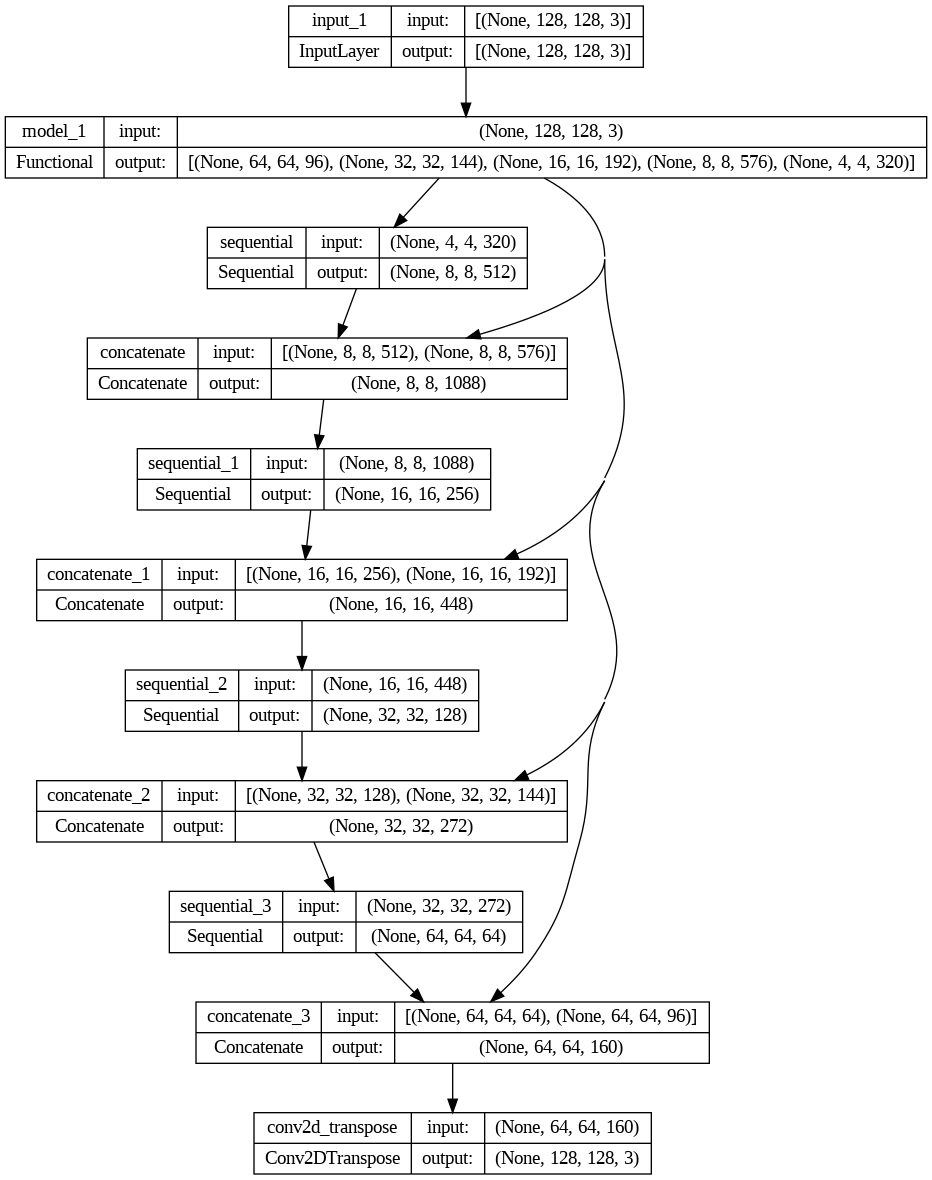

In [77]:
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [78]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(images_paths)
random.Random(1337).shuffle(masks_paths)
train_input_img_paths = images_paths[:-val_samples]
train_target_img_paths = masks_paths[:-val_samples]
val_input_img_paths = images_paths[-val_samples:]
val_target_img_paths = masks_paths[-val_samples:]

# Instantiate data Sequences for each split
batch_size = 32
train_gen = PetsSequence(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = PetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [79]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")


# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen)

Epoch 1/15
199/199 [==============================] - 74s 339ms/step - loss: 0.3974 - val_loss: 0.3705
Epoch 2/15
199/199 [==============================] - 64s 322ms/step - loss: 0.2950 - val_loss: 0.2965
Epoch 3/15
199/199 [==============================] - 64s 323ms/step - loss: 0.2741 - val_loss: 0.2682
Epoch 4/15
199/199 [==============================] - 64s 322ms/step - loss: 0.2629 - val_loss: 0.2618
Epoch 5/15
199/199 [==============================] - 64s 322ms/step - loss: 0.2546 - val_loss: 0.2583
Epoch 6/15
199/199 [==============================] - 64s 324ms/step - loss: 0.2461 - val_loss: 0.2680
Epoch 7/15
199/199 [==============================] - 64s 324ms/step - loss: 0.2390 - val_loss: 0.2721
Epoch 8/15
199/199 [==============================] - 64s 324ms/step - loss: 0.2325 - val_loss: 0.2727
Epoch 9/15
199/199 [==============================] - 67s 337ms/step - loss: 0.2259 - val_loss: 0.2529
Epoch 10/15
199/199 [==============================] - 64s 321ms/step - l

In [80]:
# predict segmentation for validation dataset
# It is not necessary to predict the result for the whole dataset, you can limit yourself to one bitch from the validation dataset 

val_gen = PetsSequence(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)

31/31 [==============================] - 9s 254ms/step


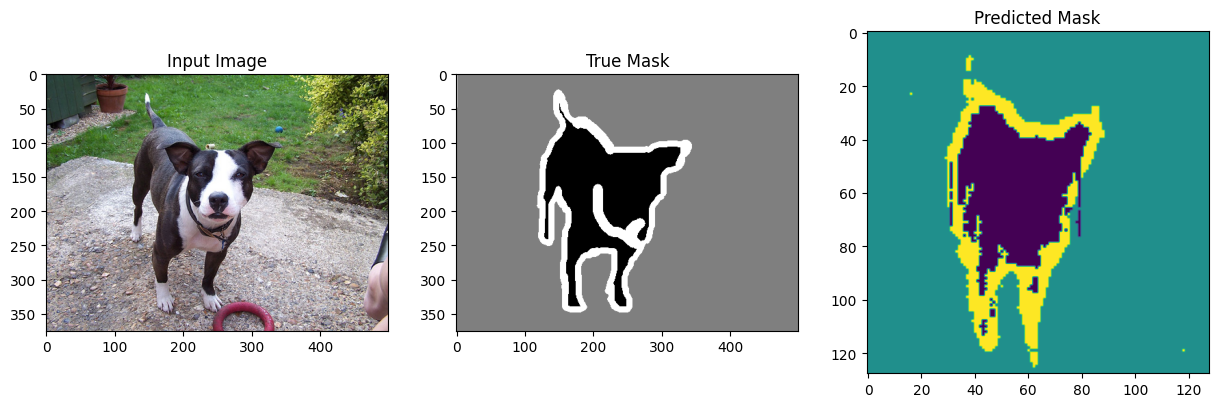

In [81]:
# display one sample prediction

i = 7

sample = load_image_and_mask(val_input_img_paths, val_target_img_paths, i)
prediction = prediction_to_img(val_preds[i])
sample += (prediction,)

display_sample(sample)

#### Task 4: Predict segmentation on your own pets



In [84]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [88]:
tests = get_paths("/Pet_for_segmentation/", "jpg")

x = np.zeros((batch_size, ) + img_size + (3, ), dtype="float32")

# Here you can use your code to load images and setting the x from Sequence.__getitem__
for j, path in enumerate (tests):
  img = load_img(path, target_size= img_size)
  x_norm = tensorflow.cast(img, tensorflow.float32) 
  x[j] = x_norm / 255.0

preds = model.predict(x)

1/1 [==============================] - 2s 2s/step


In [89]:
def display_segmentation(image, prediction):
    plt.figure(figsize=(15, 15))
    
    plt.subplot(1, 2, 1)
    plt.title('Input Image')
    plt.imshow(np.asarray(image))
    
    plt.subplot(1, 2, 2)
    plt.title('Predicted Mask')
    plt.imshow(np.asarray(prediction))

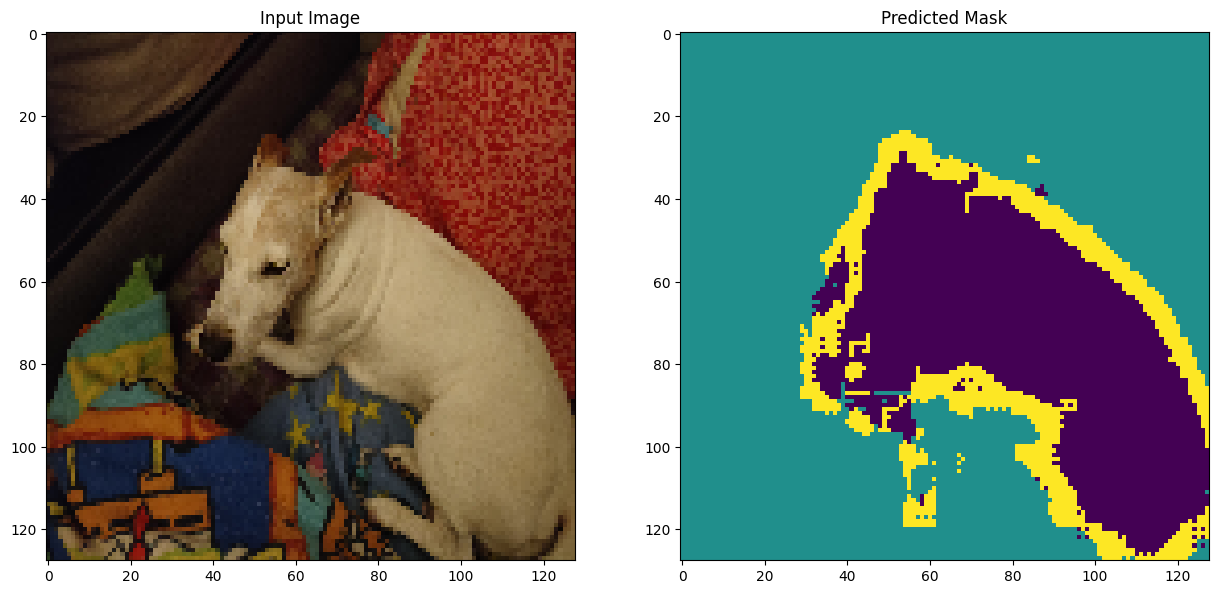

In [91]:
i = 0

image = load_img(tests[i], target_size=img_size)
prediction = prediction_to_img(preds[i])

display_segmentation(image, prediction)